# 1st Place Solution Best Model Inference Code

Hi, all

Some of our friends want to try our trained models on their own moles ;)

So we decide to publish this kernel.

This is our infernce code for one of our best single model (Effnet-B7 w/ input size 640),
which have a cv auc_all around `0.975` (validation on both 18,19,20) using chris's splits.

(To see this auc_all score you only need to set `DEBUG = False` then rerun this kernel, it takes around 7h~ to compute the whole oof on kaggle kernel)


# Usage

One can use this kernel to check your own moles by:

* Take some pictures on your moles by your phone or camera.
* Upload it to Kaggle Datasets (remember to make it private)
* Fork this kernel
* Add your uploaded dataset
* Modify `Predict` Section to predict on your own pictures!

# Thanks

In [1]:
DEBUG = True

In [2]:
!pip -q install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import geffnet

device = torch.device('cuda')

In [4]:
kernel_type = '9c_b7ns_1e_640_ext_15ep'
image_size = 640
use_amp = False
data_dir = '../input/jpeg-melanoma-768x768'
data_dir2 = '../input/jpeg-isic2019-768x768'
model_dir = '../input/melanoma-winning-models'
enet_type = 'efficientnet-b7'
batch_size = 16
num_workers = 4
out_dim = 9

use_meta = False
use_external = '_ext' in kernel_type

# Read CSV

In [5]:
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(data_dir, 'test', f'{x}.jpg'))

In [6]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train = df_train[df_train['tfrecord'] != -1].reset_index(drop=True)
# df_train['fold'] = df_train['tfrecord'] % 5
tfrecord2fold = {
    2:0, 4:0, 5:0,
    1:1, 10:1, 13:1,
    0:2, 9:2, 12:2,
    3:3, 8:3, 11:3,
    6:4, 7:4, 14:4,
}
df_train['fold'] = df_train['tfrecord'].map(tfrecord2fold)
df_train['is_ext'] = 0
df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(data_dir, 'train', f'{x}.jpg'))

df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

df_train['diagnosis'].value_counts()

unknown     26699
nevus        5191
melanoma      581
BKL           221
Name: diagnosis, dtype: int64

In [7]:
if use_external:
    df_train2 = pd.read_csv(os.path.join(data_dir2, 'train.csv'))
    df_train2 = df_train2[df_train2['tfrecord'] >= 0].reset_index(drop=True)
    df_train2['fold'] = df_train2['tfrecord'] % 5
    df_train2['is_ext'] = 1
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(data_dir2, 'train', f'{x}.jpg'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
mel_idx = diagnosis2idx['melanoma']
diagnosis2idx

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'SCC': 4,
 'VASC': 5,
 'melanoma': 6,
 'nevus': 7,
 'unknown': 8}

# Dataset

In [8]:
class SIIMISICDataset(Dataset):
    def __init__(self, csv, split, mode, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.split = split
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread(row.filepath)
        image = image[:, :, ::-1]

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)

        if self.mode == 'test':
            return torch.tensor(image).float()
        else:
            return torch.tensor(image).float(), torch.tensor(self.csv.iloc[index].target).long()

In [9]:
transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

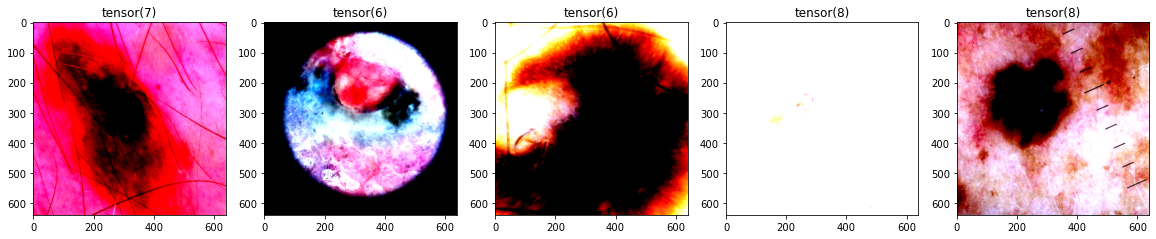

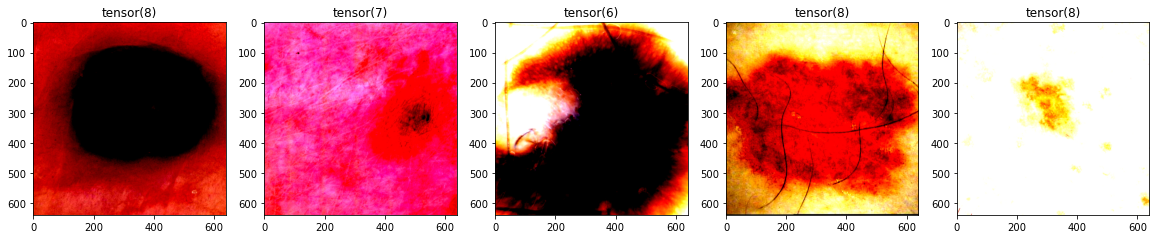

In [10]:
df_show = df_train.sample(1000)
dataset_show = SIIMISICDataset(df_show, 'train', 'val', transform=transforms_val)
# dataset_show = CloudDataset(df_train, 'train', 'val', image_size, transform=None)
# dataset_show = CloudDataset(df_test, 'test', 'test', image_size, transform=None)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        if use_meta:
            img = img[0]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [11]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim, n_meta_features=0, load_pretrained=False):

        super(enetv2, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=load_pretrained)
        self.dropout = nn.Dropout(0.5)

        in_ch = self.enet.classifier.in_features
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        x = self.myfc(self.dropout(x))
        return x

# Validation Function

In [12]:
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

    
def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):
    model.eval()
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            
            if use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return LOGITS, PROBS
    else:
        acc = (PROBS.argmax(1) == TARGETS).mean() * 100.
        auc = roc_auc_score((TARGETS==mel_idx).astype(float), LOGITS[:, mel_idx])
        auc_20 = roc_auc_score((TARGETS[is_ext==0]==mel_idx).astype(float), LOGITS[is_ext==0, mel_idx])
        return val_loss, acc, auc, auc_20

In [13]:
PROBS = []
dfs = []

for fold in range(5):
    i_fold = fold

    df_valid = df_train[df_train['fold'] == i_fold]
    if DEBUG:
        df_valid = pd.concat([
            df_valid[df_valid['target'] == mel_idx].sample(10),
            df_valid[df_valid['target'] != mel_idx].sample(10)
        ])
    print(df_valid.shape)

    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=0, out_dim=out_dim)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{i_fold}.pth')
    state_dict = torch.load(model_file)
    state_dict = {k.replace('module.', ''): state_dict[k] for k in state_dict.keys()}
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    this_LOGITS, this_PROBS = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values, n_test=8, get_output=True)
    PROBS.append(this_PROBS)
    dfs.append(df_valid)
    
dfs = pd.concat(dfs).reset_index(drop=True)
dfs['pred'] = np.concatenate(PROBS).squeeze()[:, mel_idx]

(20, 14)



(20, 14)



(20, 14)



(20, 14)



(20, 14)


In [14]:
# Raw auc_all
roc_auc_score(dfs['target'] == mel_idx, dfs['pred'])

0.9536000000000001

In [15]:
# Rank per fold auc_all
dfs2 = dfs.copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

0.952

In [16]:
# Raw auc_2020
roc_auc_score(dfs[dfs['is_ext']==0]['target']==mel_idx, dfs[dfs['is_ext']==0]['pred'])

0.8969696969696969

In [17]:
# Rank per fold auc_2020
dfs2 = dfs[dfs.is_ext==0].copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

0.9030303030303031

# Predict

In [18]:
n_test = 8
df_test = df_test if not DEBUG else df_test.head(batch_size * 2)
dataset_test = SIIMISICDataset(df_test, 'test', 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [19]:
models = []
for i_fold in range(5):
    model = enetv2(enet_type, n_meta_features=0, out_dim=out_dim)
    model = model.to(device)
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{i_fold}.pth')
    state_dict = torch.load(model_file)
    state_dict = {k.replace('module.', ''): state_dict[k] for k in state_dict.keys()}
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    models.append(model)
len(models)

5

In [20]:
OUTPUTS = []
PROBS = []

with torch.no_grad():
    for (data) in tqdm(test_loader):

        if use_meta:
            data, meta = data
            data, meta = data.to(device), meta.to(device)
            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            for I in range(n_test):
                l = model(get_trans(data, I), meta)
                probs += l.softmax(1)
        else:
            data = data.to(device)
            probs = torch.zeros((data.shape[0], out_dim)).to(device)
            for model in models:
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    probs += l.softmax(1)

        probs /= n_test * len(models)
        PROBS.append(probs.detach().cpu())

PROBS = torch.cat(PROBS).numpy()
OUTPUTS = PROBS[:, mel_idx]

In [21]:
df_test['target'] = OUTPUTS
df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)

In [22]:
df_test[['image_name', 'target']].head()

,image_name,target
0,ISIC_0052060,0.000155
1,ISIC_0052349,0.001239
2,ISIC_0058510,0.001706
3,ISIC_0073313,0.000661
4,ISIC_0073502,0.000920


In [23]:
df_test.shape

(32, 9)

# Infer Single Image

In [24]:
#patient test images processing
# patient 1 image name
in1 = 'hello'
# patient 1 patient_id
pi1 = 'IP23232'
# patient 1 sex
s1 = 'male'
# patient 1 age
a1 = 70.0
# patient 1 anatom_site_general_challenge. where its located
asgc1 = 'torso'
# patient 1 image filepath
f1 = '../input/jpeg-melanoma-768x768/test/ISIC_0052060.jpg'
import csv
with open('datasettesting.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_name", "patient_id", "sex", "age_approx", "anatom_site_general_challenge", "width", "height", "filepath"])
    writer.writerow([in1,pi1, s1, a1, asgc1, 6000, 4000, f1])

In [25]:
df_single_image = pd.read_csv('datasettesting.csv')
df_single_image

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height,filepath
0,hello,IP23232,male,70.0,torso,6000,4000,../input/jpeg-melanoma-768x768/test/ISIC_00520...


In [26]:
# as we only read a single image, so we don't need a dataloader
dataset_test = SIIMISICDataset(df_single_image, 'test', 'test', transform=transforms_val)
image = dataset_test[0]  
image = image.to(device).unsqueeze(0)  # a single image need to be added a new axis to act like batch_size = 1

In [27]:
with torch.no_grad():
    probs = torch.zeros((image.shape[0], out_dim)).to(device)
    for model in models:
        for I in range(n_test):
            l = model(get_trans(image, I))
            probs += l.softmax(1)
probs /= len(models) * n_test

In [28]:
prediction = probs[:, mel_idx].item()
prediction

0.0001545582344988361